# Using Data Science to Determine Popular Children's Books Elements
## By Jessica Dassanayake
### CISC372 Final Project

In [3]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud

stemmer = PorterStemmer()

In [4]:
book_df = pd.read_csv('children_stories.Csv', encoding = "ISO-8859-1")
book_df

,names,cats,desc
0,HIDE AND SEEK,Age 2-9,Was it just another game of hide and seek? No....
1,GINGER THE GIRAFFE,Age 2-9,Read this warm tale of camaraderie and affecti...
2,DOING MY CHORES,Age 2-9,Love shines through this great illustrated kid...
3,ABE THE SERVICE DOG,Age 2-9,Abe was a real Service Dog who dedicated his l...
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,The class took a little train and went deep in...
...,...,...,...
425,Carrying the Elephant: A Memoir of Love and Loss,Age 11+,In the 72 prose poems that make up this unusua...
426,War and Peas,Age 8+,Nearly forty years after its original appearan...
427,Love that Dog,Age 9-12,"Jack has a great sadness in his life, but he i..."
428,A Pilgrim's Progress,Age 9+,'I had a dream last night ... large enough to ...


# Data Cleaning

The following code block was copied and modified from the following Python notebook on Kaggle: https://www.kaggle.com/accountstatus/best-children-book-ideas-for-different-ages

In [5]:
arr=book_df['cats']
min=[]
max=[]
# For each book, the cats (age) column is taken to derive the minimum and maximum age.
# For age ranges that provide a minimum, but not a maximum (i.e. Age 3+), 15 is used as
# the maximum because 15 is the maximum age for children for this dataset.
for i in arr:
    x=(i.replace('Age ',''))
    if '-' in x:
        mi,mx=x.split('-')
        mi,mx=int(mi),int(mx)
        min.append(mi)
        max.append(int(mx))
    else:
        if x.split('+')[0].isdigit():
            min.append(int(x.split('+')[0]))
        else:
            min.append(0)
        max.append(15)
book_df['min_age']=min
book_df['max_age']=max

In [6]:
book_df.head()

,names,cats,desc,min_age,max_age
0,HIDE AND SEEK,Age 2-9,Was it just another game of hide and seek? No....,2,9
1,GINGER THE GIRAFFE,Age 2-9,Read this warm tale of camaraderie and affecti...,2,9
2,DOING MY CHORES,Age 2-9,Love shines through this great illustrated kid...,2,9
3,ABE THE SERVICE DOG,Age 2-9,Abe was a real Service Dog who dedicated his l...,2,9
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,The class took a little train and went deep in...,2,9


In [7]:
# This shows the distribution of books based on the minimum age
book_df.groupby("min_age").count()

,names,cats,desc,max_age
min_age,,,,
0,55,55,55,55
1,19,19,19,19
2,53,53,53,53
3,54,54,54,54
4,30,30,30,30
5,22,22,22,22
6,27,27,27,27
7,36,36,36,36
8,31,31,31,31


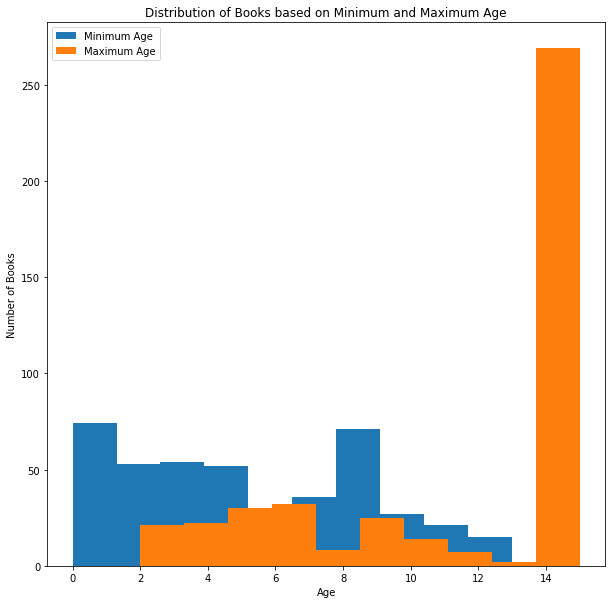

In [13]:
# A histogram is plotted showing the minimum and maximum age distribution for the books
fig1 = plt.figure(figsize=(10, 10))
plt.title("Distribution of Books based on Minimum and Maximum Age") 
plt.xlabel('Age')
plt.ylabel('Number of Books')
plt.hist(book_df["min_age"], label= "Minimum Age")
plt.hist(book_df["max_age"], label= "Maximum Age")
leg = plt.legend()
plt.show()

Based on the table presented from the groupby function, as well as the histogram, we can determine common age groups. Using the minimum and maximum age features to look at the book distributions, I determined 3 age groups. I used the peaks in minimum and maximum age to do this. The age groups I will be analyzing further are Age 0-3, Age 4-7, and Age 8+. Using my knowledge of reading levels, these make sense as they correspond with the categories of pre-K, younger elementary school kids, and  older elementary school kids.

In [7]:
# replace special characters
book_df["desc"]=book_df["desc"].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")

# convert strings to lowercase
book_df["desc"]=book_df["desc"].str.lower()

# Data Analysis

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# stopwords are unimportant words that are commonly used
# we remove stopwords so that the model focuses only on important words
stopset = stopwords.words('english')

# This function will take a description column, tokenize words, stem words, and build a bag-of-words
# Parameter: desc_column, a description column
# Returns: a dictionary (bag-of-words model)
def text_to_dict(desc_column):
  d = desc_column.values
  dic={}
  sentences=[]

  for i in d:
    tokens=word_tokenize(str(i))  #words are tokenized
    tokens = [w for w in tokens if not w in stopset]  #remove stopwords
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stems = [stemmer.stem(t) for t in filtered_tokens if len(t) > 0]  #stem the tokens to have the root
    
    # this is creating a dictionary with the frequency of each words (bag-of-words model)
    for word in stems:
      if word not in dic: # new word to dictionary
        dic[word]=1 #set frequency as 1
      else:
        dic[word]+=1 #increase frequency by 1

  dic={k: v for k, v in sorted(dic.items(), key=lambda item: item[1],reverse=True)}
  return dic

Below, bag-of-word dictionaries are created for each age group. This is followed by the generation of a word cloud and the output of a dataframe showing the frequency of the top 30 words.

In [19]:
# This function generates a word cloud for a provided dictionary
# Parameter: dic, a dictionary
# Return: none, but a word cloud will be presented
def wordcloud_gen(dic):  
  wordcloud = WordCloud(background_color='black',
  width=2000, height=1500).generate_from_frequencies(dic)
  plt.figure(figsize=(9,6))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

## Books with a minimum age of 0-3 years old

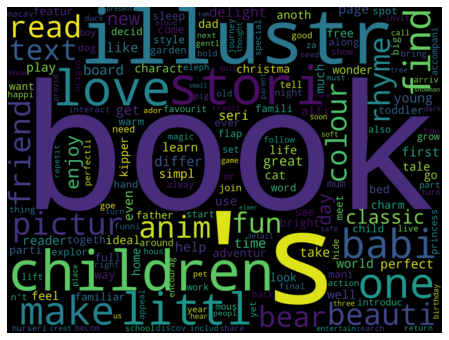

In [24]:
zero_to_three = book_df[book_df.min_age <= 3]
zero_to_three_desc = zero_to_three["desc"]
zero_to_three_dic = text_to_dict(zero_to_three_desc)

wordcloud_gen(zero_to_three_dic)

In [30]:
word_freq = pd.DataFrame.from_dict(zero_to_three_dic, orient="index")
word_freq.columns = ["Frequency"]
word_freq.head(30)

,Frequency
book,185
's,171
illustr,109
children,96
stori,87
love,75
littl,68
one,63
babi,55
make,53


## Books with a minimum age of 4-7 years old

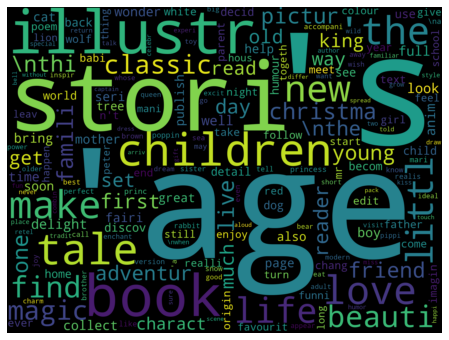

In [21]:
four_to_seven = book_df[(book_df.min_age <= 7) & (book_df.min_age >= 4)]
four_to_seven_desc = four_to_seven["desc"]
four_to_seven_dic = text_to_dict(four_to_seven)

wordcloud_gen(four_to_seven_dic)


In [31]:
word_freq = pd.DataFrame.from_dict(four_to_seven_dic, orient="index")
word_freq.columns = ["Frequency"]
word_freq.head(30)

,Frequency
's,119
'age,115
stori,98
illustr,68
book,62
children,56
tale,51
love,42
'the,40
make,40


## Books with a minimum age of 8+ years old

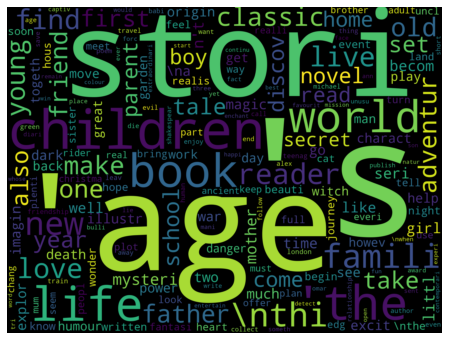

In [22]:
eight_plus = book_df[book_df.min_age >= 8]
eight_plusdesc = eight_plus["desc"]
eight_plus_dic = text_to_dict(eight_plus)

wordcloud_gen(eight_plus_dic)

In [32]:
word_freq = pd.DataFrame.from_dict(eight_plus_dic, orient="index")
word_freq.columns = ["Frequency"]
word_freq.head(30)

,Frequency
's,207
'age,134
stori,108
children,68
'the,52
life,51
book,48
world,44
famili,43
\nthi,43
